In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook


%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(2019)
tf.set_random_seed(2019)
NSIZE = 224
PREPROCESS_GAMMAX=10
BATCH_SIZE =32

In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
print(train_df.shape)
train_df.head()

train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
print(train_df.shape)
train_df.head()
def get_label(diagnosis):
    return str(diagnosis)
train_df['label'] = train_df.diagnosis.apply(get_label)
train_df['id_code'] = train_df['id_code'].apply(lambda x:  x + '.png')
print(train_df.head(10))

(3662, 2)
(3662, 2)
            id_code  diagnosis label
0  000c1434d8d7.png          2     2
1  001639a390f0.png          4     4
2  0024cdab0c1e.png          1     1
3  002c21358ce6.png          0     0
4  005b95c28852.png          0     0
5  0083ee8054ee.png          4     4
6  0097f532ac9f.png          0     0
7  00a8624548a9.png          2     2
8  00b74780d31d.png          2     2
9  00cb6555d108.png          1     1


# Preprocessing


In [4]:

def ben_color (img) :
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , PREPROCESS_GAMMAX) ,-4 ,128)
    return img
def preprocess_image(img, color=False):
    def crop_image_from_gray(img,tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol

            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0): # image is too dark so that we crop out everything,
                return img # return original image
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img
    def circle_crop(img, sigmaX=10):   
        """
        Create circular crop around image centre    
        """    

        img = crop_image_from_gray(img)    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, depth = img.shape    

        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))

        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (NSIZE, NSIZE))
        return img 
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (NSIZE, NSIZE))
    img = ben_color(img)
    #im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return img


CPU times: user 4.44 s, sys: 124 ms, total: 4.56 s
Wall time: 3.08 s


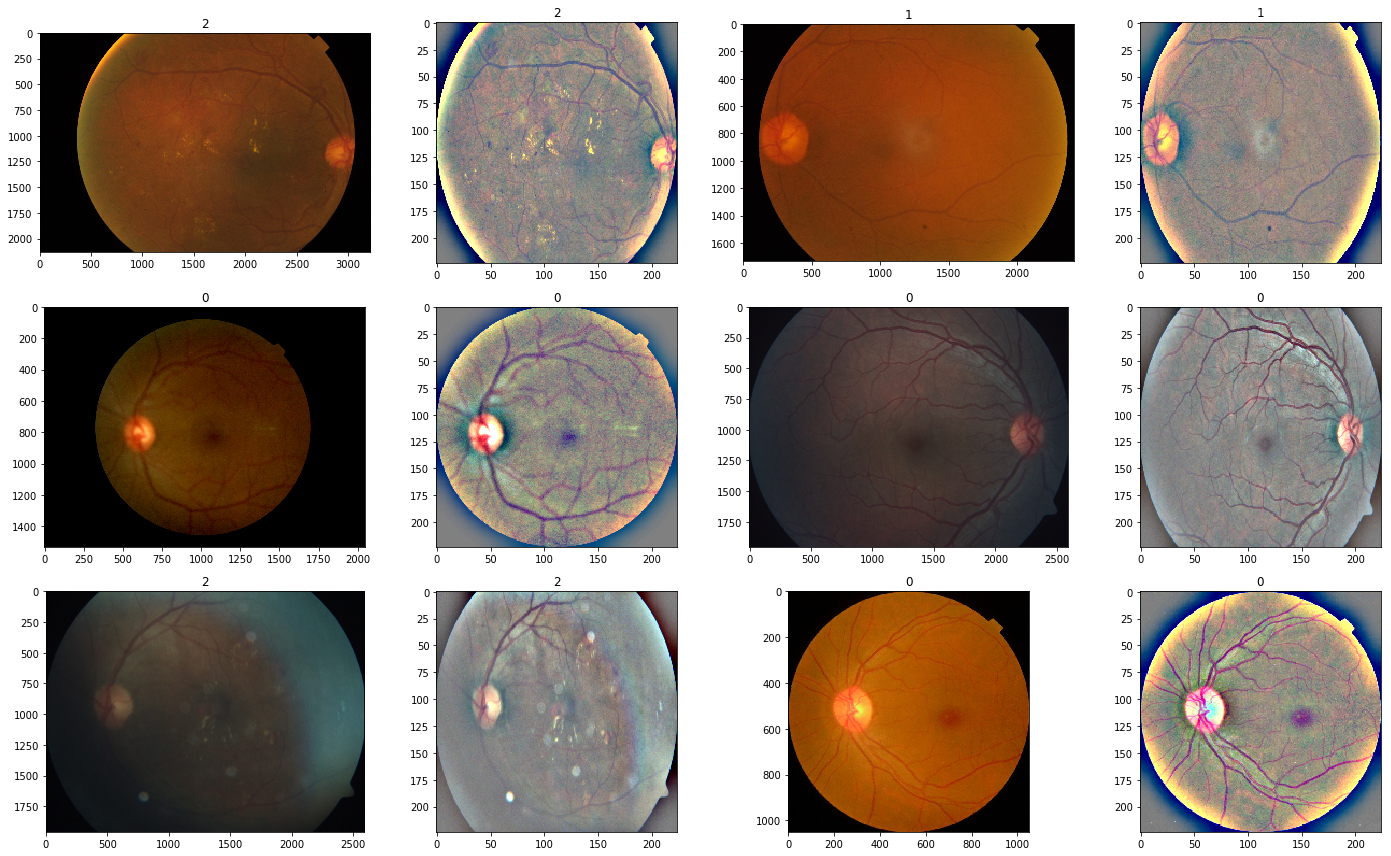

In [13]:
%%time
def preprocess_display(df, columns=4, rows=3, desired_size=NSIZE):
    
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows)[::2]:
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']

        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}')

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgProc = preprocess_image(img)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
        fig.add_subplot(rows, columns, i+2)
        plt.title(image_id)
        plt.imshow(imgProc)
    plt.tight_layout()

preprocess_display(train_df)

## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [6]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(y_train.shape)

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=1))
print("Multilabel version:", y_train_multi.sum(axis=1))

(3662, 5)
Original y_train: [1 1 1 ... 1 1 1]
Multilabel version: [3 5 2 ... 3 1 3]


In [7]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=[0.85,1],  # set range for random zoom
        #rotation_range=30,
        fill_mode="nearest",
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=preprocess_image,
        validation_split=0.15
        
    )


data_gen=create_datagen().flow_from_dataframe(
    dataframe=train_df, 
    directory="../input/aptos2019-blindness-detection/train_images/", 
    x_col='id_code', 
    y_col='label', 
    class_mode="categorical", 
    batch_size=BATCH_SIZE,
    target_size=(NSIZE,NSIZE),
    subset="training")

val_gen=create_datagen().flow_from_dataframe(
    dataframe=train_df, 
    directory="../input/aptos2019-blindness-detection/train_images/", 
    x_col='id_code', 
    y_col='label', 
    class_mode="categorical", 
    batch_size=128,
    target_size=(NSIZE,NSIZE),
    subset="validation")


Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


W0810 05:41:21.008582 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.023019 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.037564 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.052809 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.067095 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.081409 140157468436224 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 05:41:21.095502 140157

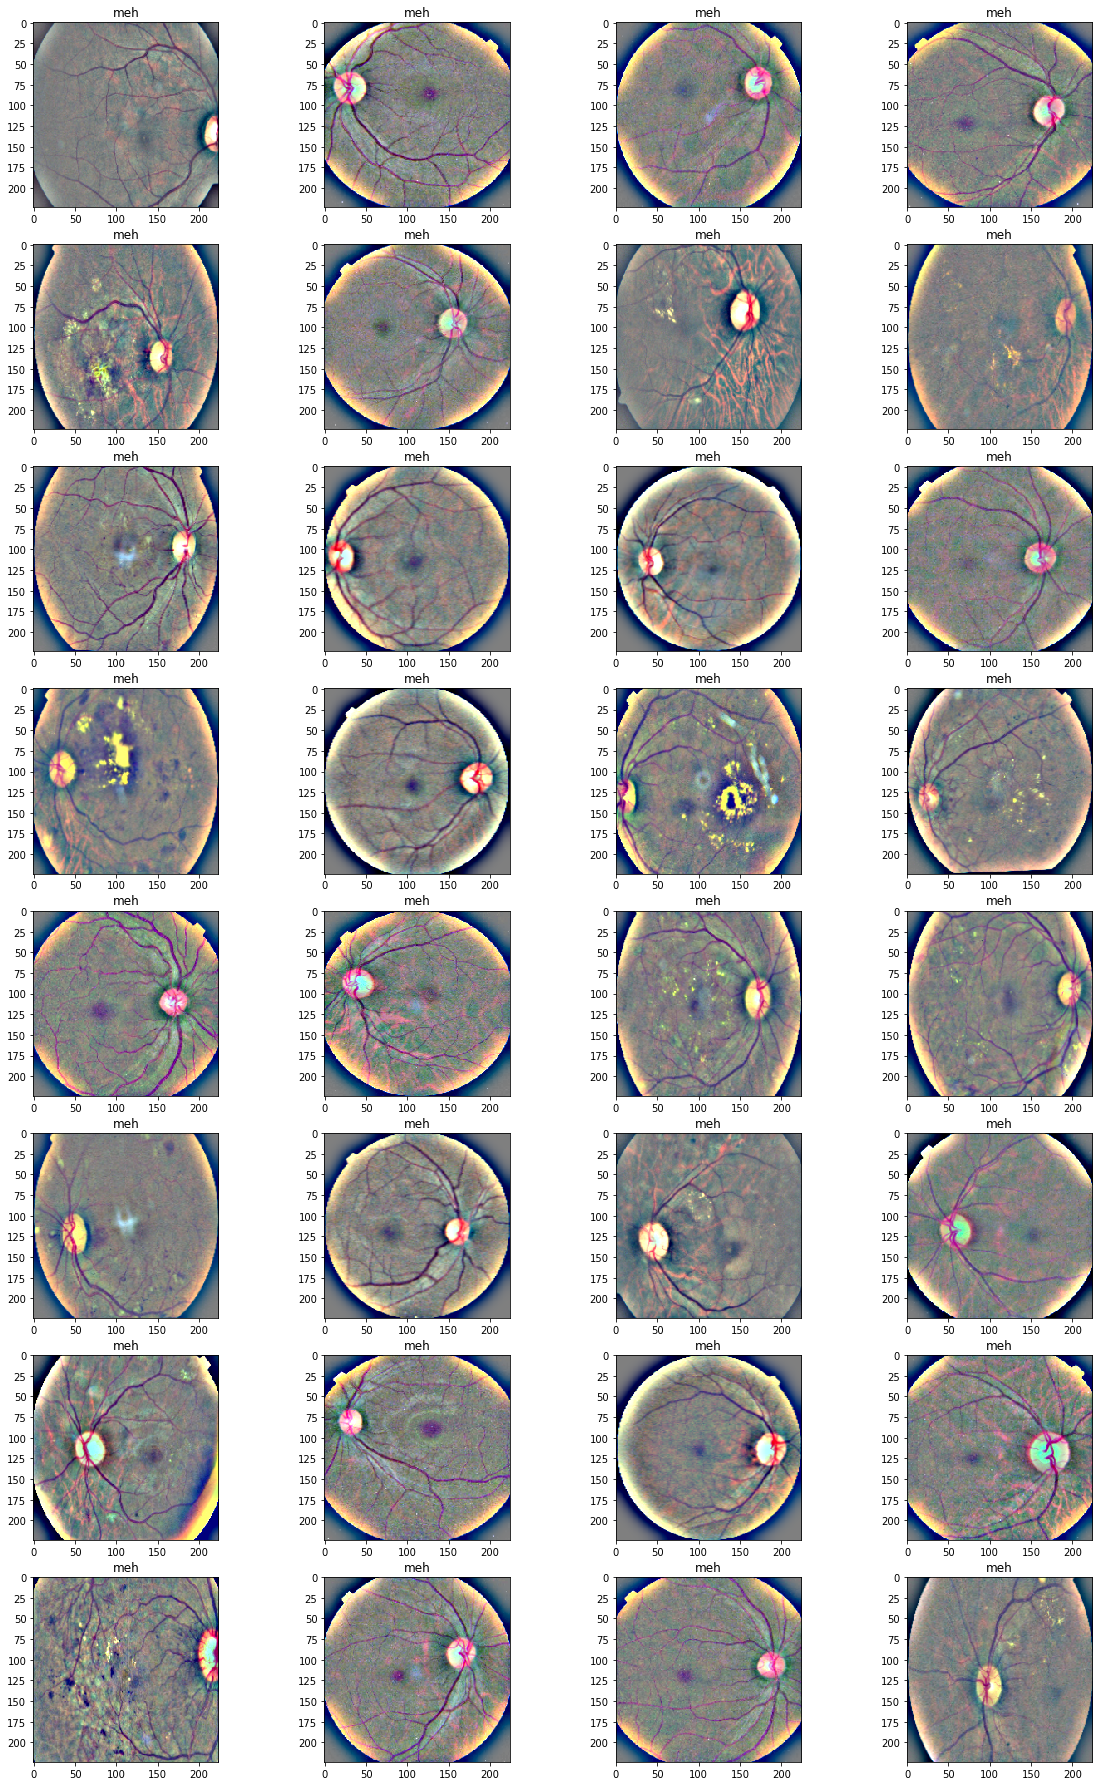

In [8]:
def display_generated_image(data_generator):
    for X, Y in data_generator:
        columns = 4
        rows = 8
        fig=plt.figure(figsize=(5*columns, 4*rows))
        for i in range(columns*rows):
            img = np.asarray(X[i].reshape(NSIZE,NSIZE,3),np.int32)

            fig.add_subplot(rows, columns, i+1)
            plt.title('meh')
            plt.imshow(img)

        plt.show()
        break
display_generated_image(data_gen)

In [9]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        for X_val, y_val in val_gen:
            y_val= np.argmax(y_val, axis=1)
            #y_val = y_val.sum(axis=1) - 1
            y_pred = np.argmax(model.predict(X_val),axis=1)
            print(y_val)
            print(y_pred)

            _val_kappa = cohen_kappa_score(
                y_val,
                y_pred, 
                weights='quadratic'
            )

            self.val_kappas.append(_val_kappa)

            print(f"val_kappa: {_val_kappa:.4f}")

            if _val_kappa == max(self.val_kappas):
                print("Validation Kappa has improved. Saving model.")
                self.model.save('model.h5')
            break

    
    

In [10]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

W0810 05:41:26.603851 140157468436224 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0810 05:41:26.605037 140157468436224 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0810 05:41:26.611233 140157468436224 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0810 05:41:26.633832 140157468436224 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The n

In [14]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
kappa_metrics = Metrics()

STEP_SIZE_TRAIN=data_gen.n//data_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

history = model.fit_generator(
    data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=15,
    validation_data=val_gen,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[kappa_metrics],
    verbose=1
)

Epoch 1/15
64/97 [==================>...........] - ETA: 2:21 - loss: 0.6057 - acc: 0.6902

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [ ]:
plt.plot(kappa_metrics.val_kappas)